# Evaluation of hourly bias-corrected WBGT


In [1]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.CRITICAL)

import glob
import xarray as xr
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import pandas as pd
import cartopy.feature as cfeature


In [31]:
# Variable specific settings
var = 'wbgt'
name = 'wet-bulb globe temperature'
units = '°C'
cmap = 'RdBu_r'

inst = "BOM" #"BOM" #"CSIRO"
if inst =="CSIRO":
    version = "v20251120"
else:
    version = "v20250901"
    
gcm= "EC-Earth3"
run = "r1i1p1f1"

rcm = "BARPA-R" #"BARPA-R" #"CCAM-v2203-SN"
yr_start ="1980-01-01"
yr_end ="2014-12-31"
reference = "BARRA-R2"
ssp = "ssp126"
start_date_fut = '2065-01-01'
end_date_fut = '2099-12-31'

In [3]:
# get data historical
path_ref= f"/g/data/ia39/australian-climate-service/test-data/BARRA2/output/reanalysis/AUST-11/BOM/ERA5/historical/hres/BARRAR2/v1/1hr/wbgt/v20250901-native-contiguous/"
path_raw_model= f"/g/data/ia39/australian-climate-service/test-data/CORDEX/output-CMIP6/DD/AUST-11i/{inst}/{gcm}/historical/{run}/{rcm}/v1-r1/1hr/wbgt/{version}-bilinear-contiguous/"
path_correct_model = f"/g/data/ia39/australian-climate-service/test-data/CORDEX/output-CMIP6/bias-adjusted-output/AUST-11i/{inst}/{gcm}/historical/{run}/{rcm}/v1-r1-ACS-QME-BARRAR2-1980-2022/1hr/wbgtAdjust/{version}/"

files_ref= glob.glob(path_ref + '*.nc')
files_raw_model= glob.glob(path_raw_model + '*.nc')
files_correct_model= glob.glob(path_correct_model + '*.nc')

da_ref = xr.open_mfdataset(files_ref, engine='h5netcdf',chunks={}).wbgt.sel(time=slice(yr_start,yr_end)) 
da_raw_model = xr.open_mfdataset(files_raw_model, engine='h5netcdf',chunks={}).wbgt.sel(time=slice(yr_start,yr_end))
da_correct_model = xr.open_mfdataset(files_correct_model, engine='h5netcdf',chunks={}).wbgtAdjust.sel(time=slice(yr_start,yr_end))


In [32]:
# get data future
path_raw_model_fut= f"/g/data/ia39/australian-climate-service/test-data/CORDEX/output-CMIP6/DD/AUST-11i/{inst}/{gcm}/{ssp}/{run}/{rcm}/v1-r1/1hr/wbgt/{version}-bilinear-contiguous/"
path_correct_model_fut = f"/g/data/ia39/australian-climate-service/test-data/CORDEX/output-CMIP6/bias-adjusted-output/AUST-11i/{inst}/{gcm}/{ssp}/{run}/{rcm}/v1-r1-ACS-QME-BARRAR2-1980-2022/1hr/wbgtAdjust/{version}/"

files_raw_model_fut= glob.glob(path_raw_model_fut + '*.nc')
files_correct_model_fut= glob.glob(path_correct_model_fut + '*.nc')

da_raw_model_fut = xr.open_mfdataset(files_raw_model_fut, engine='h5netcdf',chunks={}).wbgt.sel(time=slice(start_date_fut,end_date_fut))
da_correct_model_fut = xr.open_mfdataset(files_correct_model_fut, engine='h5netcdf',chunks={}).wbgtAdjust.sel(time=slice(start_date_fut,end_date_fut))

## Annual mean 

In [11]:
# Metric calculation
# Annual mean
# def calc_mean(da):
#     """Calculate the mean"""
#     if var == 'pr':
#         mean = da.groupby('time.year').sum(dim="time").mean(dim='year').compute()
#     else:
#         mean = da.groupby('time.year').mean(dim="time").mean(dim='year').compute()
        
#     return mean

In [12]:
# Annual mean
da_ref_mean = da_ref.groupby('time.year').mean(dim="time").mean(dim='year').compute()

In [13]:
da_raw_model_mean = da_raw_model.groupby('time.year').mean(dim="time").mean(dim='year').compute()

In [14]:
da_corret_model_mean = da_correct_model.groupby('time.year').mean(dim="time").mean(dim='year').compute()

In [15]:
# Bias Annual mean
task="annual-mean-bias"
calc= "annual mean"
da_raw_model_mean_bias = da_raw_model_mean - da_ref_mean
mae_da_raw_model_mean_bias = np.nanmean(np.abs(da_raw_model_mean_bias))

da_corret_model_mean_bias = da_corret_model_mean - da_ref_mean
mae_da_corret_model_mean_bias = np.nanmean(np.abs(da_corret_model_mean_bias)) 

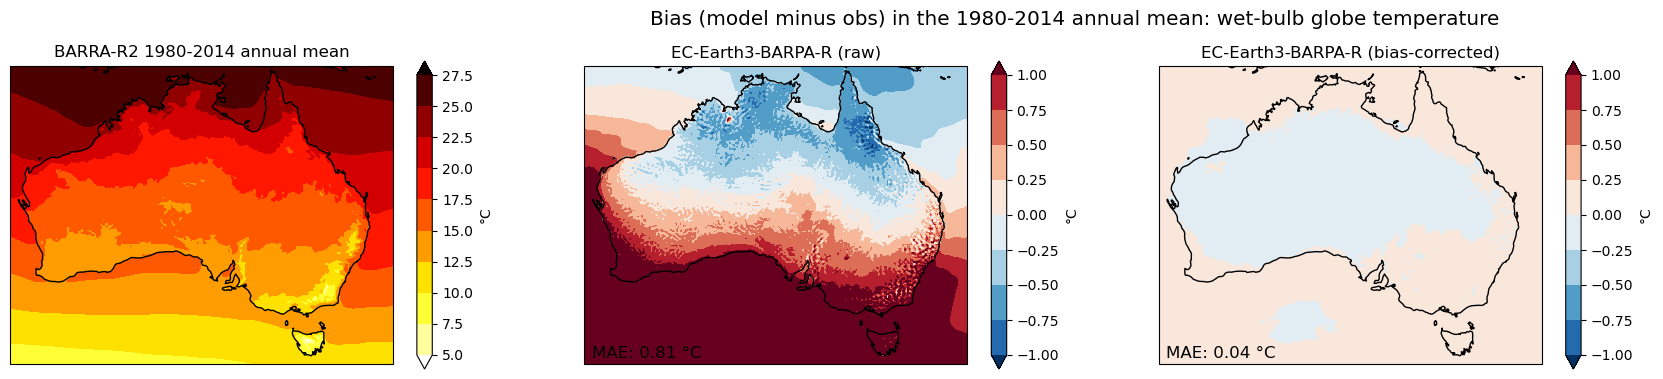

In [16]:
# Plot Annul Mean

levels_bias = np.arange(-1, 1.25, 0.25)
levels_ref = np.arange(5, 30, 2.5)

ncols = 3 
nrows = 1
plot_nums = np.arange(1, (ncols * nrows) + 1)

fig = plt.figure(figsize=[7 * ncols, 4 * nrows])

plot_index = 0

ax1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
da_ref_mean.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="hot_r",
    levels=levels_ref,
    extend='both',
    cbar_kwargs={'label': units},
)
ax1.set_title(f"{reference} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}")
ax1.coastlines()


plot_index = plot_index + 1

ax2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
da_raw_model_mean_bias.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels_bias,
    extend='both',
    cbar_kwargs={'label': units},
)
ax2.text(0.02, 0.02, f'MAE: {mae_da_raw_model_mean_bias:.2f} {units}', transform=ax2.transAxes, fontsize='large')
ax2.set_title(gcm+'-'+rcm+' (raw)')
ax2.coastlines()


plot_index = plot_index + 1

ax3 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
da_corret_model_mean_bias.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels_bias,
    extend='both',
    cbar_kwargs={'label': units},
)
ax3.text(0.02, 0.02, f'MAE: {mae_da_corret_model_mean_bias:.2f} {units}', transform=ax3.transAxes, fontsize='large')
ax3.set_title(gcm+'-'+rcm+' (bias-corrected)')
ax3.coastlines()

outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
fig.text(0.43, 0.97,  
         f"Bias (model minus obs) in the {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}: {name}", fontsize='x-large')
plt.savefig(outfile, dpi=300, bbox_inches='tight')

## Change signal

In [33]:
# Change signal
def calc_change_signal(da_future, da):
    """Calculate the difference in the change signal between GCM and RCM """
    
    change_signal = (da_future.mean(dim='time') - da.mean(dim='time')).compute()
    
    return change_signal

In [34]:
# change signal
change_raw_model = calc_change_signal(da_raw_model_fut, da_raw_model) 

In [35]:
change_correct_model = calc_change_signal(da_correct_model_fut, da_correct_model) 

In [36]:
# Change signal spatial average

task="change_signal"
calc= "change signal"

ave_change_raw_model = np.nanmean(change_raw_model) 
ave_change_correct_model = np.nanmean(change_correct_model) 


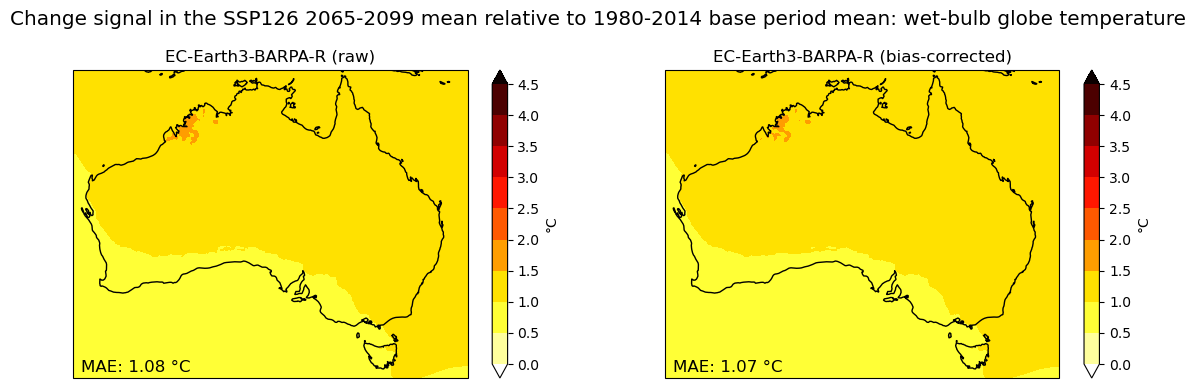

In [37]:
# Plot Change signal

levels_bias = np.arange(0, 5, 0.5)

ncols = 2 
nrows = 1
plot_nums = np.arange(1, (ncols * nrows) + 1)

fig = plt.figure(figsize=[7 * ncols, 4 * nrows])

plot_index = 0


ax2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
change_raw_model.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    levels=levels_bias,
    extend='both',
    cbar_kwargs={'label': units},
)
ax2.text(0.02, 0.02, f'MAE: {ave_change_raw_model:.2f} {units}', transform=ax2.transAxes, fontsize='large')
ax2.set_title(gcm+'-'+rcm+' (raw)')
ax2.coastlines()


plot_index = plot_index + 1

ax3 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
change_correct_model.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    levels=levels_bias,
    extend='both',
    cbar_kwargs={'label': units},
)
ax3.text(0.02, 0.02, f'MAE: {ave_change_correct_model:.2f} {units}', transform=ax3.transAxes, fontsize='large')
ax3.set_title(gcm+'-'+rcm+' (bias-corrected)')
ax3.coastlines()

outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{start_date_fut.split('-')[0]}-{end_date_fut.split('-')[0]}_rel_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}_{ssp}.png"
plt.suptitle(f"Change signal in the {ssp.upper()} {start_date_fut.split('-')[0]}-{end_date_fut.split('-')[0]} mean relative to {yr_start.split('-')[0]}-{yr_end.split('-')[0]} base period mean: {name}", fontsize='x-large',y=1.03)
plt.savefig(outfile, dpi=300, bbox_inches='tight')



# Diurnal cycle

In [22]:
ref = da_ref.compute()

In [23]:
raw = da_raw_model.compute()

In [24]:
corrected = da_correct_model.compute()

In [25]:
# Plot city-based diurnal cycle
cities = {
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Darwin': {'lat': -12.5, 'lon': 131},
    'Cairns': {'lat': -16.9, 'lon': 145},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},
}

results = []

for city, coords in cities.items():

    # Select nearest grid point for each dataset
    ref_city = ref.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
    raw_city = raw.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
    corrected_city = corrected.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')

    # Convert to pandas
    df_city = pd.DataFrame({
        'reference': ref_city.values,
        'raw': raw_city.values,
        'bias_corrected': corrected_city.values
    }, index=pd.to_datetime(ref_city['time'].values))

    # Compute hourly means for diurnal cycle
    for hour in range(24):
        subset = df_city[df_city.index.hour == hour]
        hourly_ref = subset['reference'].mean()
        hourly_raw = subset['raw'].mean()
        hourly_bc = subset['bias_corrected'].mean()

        results.append([hour, city, hourly_ref, hourly_raw, hourly_bc])

diurnal_df = pd.DataFrame(results, columns=['Hour', 'City', 'Hourly_Ref', 'Hourly_Raw', 'Hourly_BC'])
print(diurnal_df)


     Hour          City  Hourly_Ref  Hourly_Raw  Hourly_BC
0       0  Port Hedland   21.521814   21.600258  21.504210
1       1  Port Hedland   23.244173   23.394688  23.217089
2       2  Port Hedland   24.477716   24.728146  24.449333
3       3  Port Hedland   25.358002   25.562931  25.337015
4       4  Port Hedland   25.682631   25.951334  25.662048
..    ...           ...         ...         ...        ...
259    19         Perth   12.778534   13.818782  12.781164
260    20         Perth   12.554146   13.586112  12.559127
261    21         Perth   12.247874   13.403107  12.215620
262    22         Perth   12.702377   13.799666  12.678013
263    23         Perth   13.701324   14.748255  13.691685

[264 rows x 5 columns]


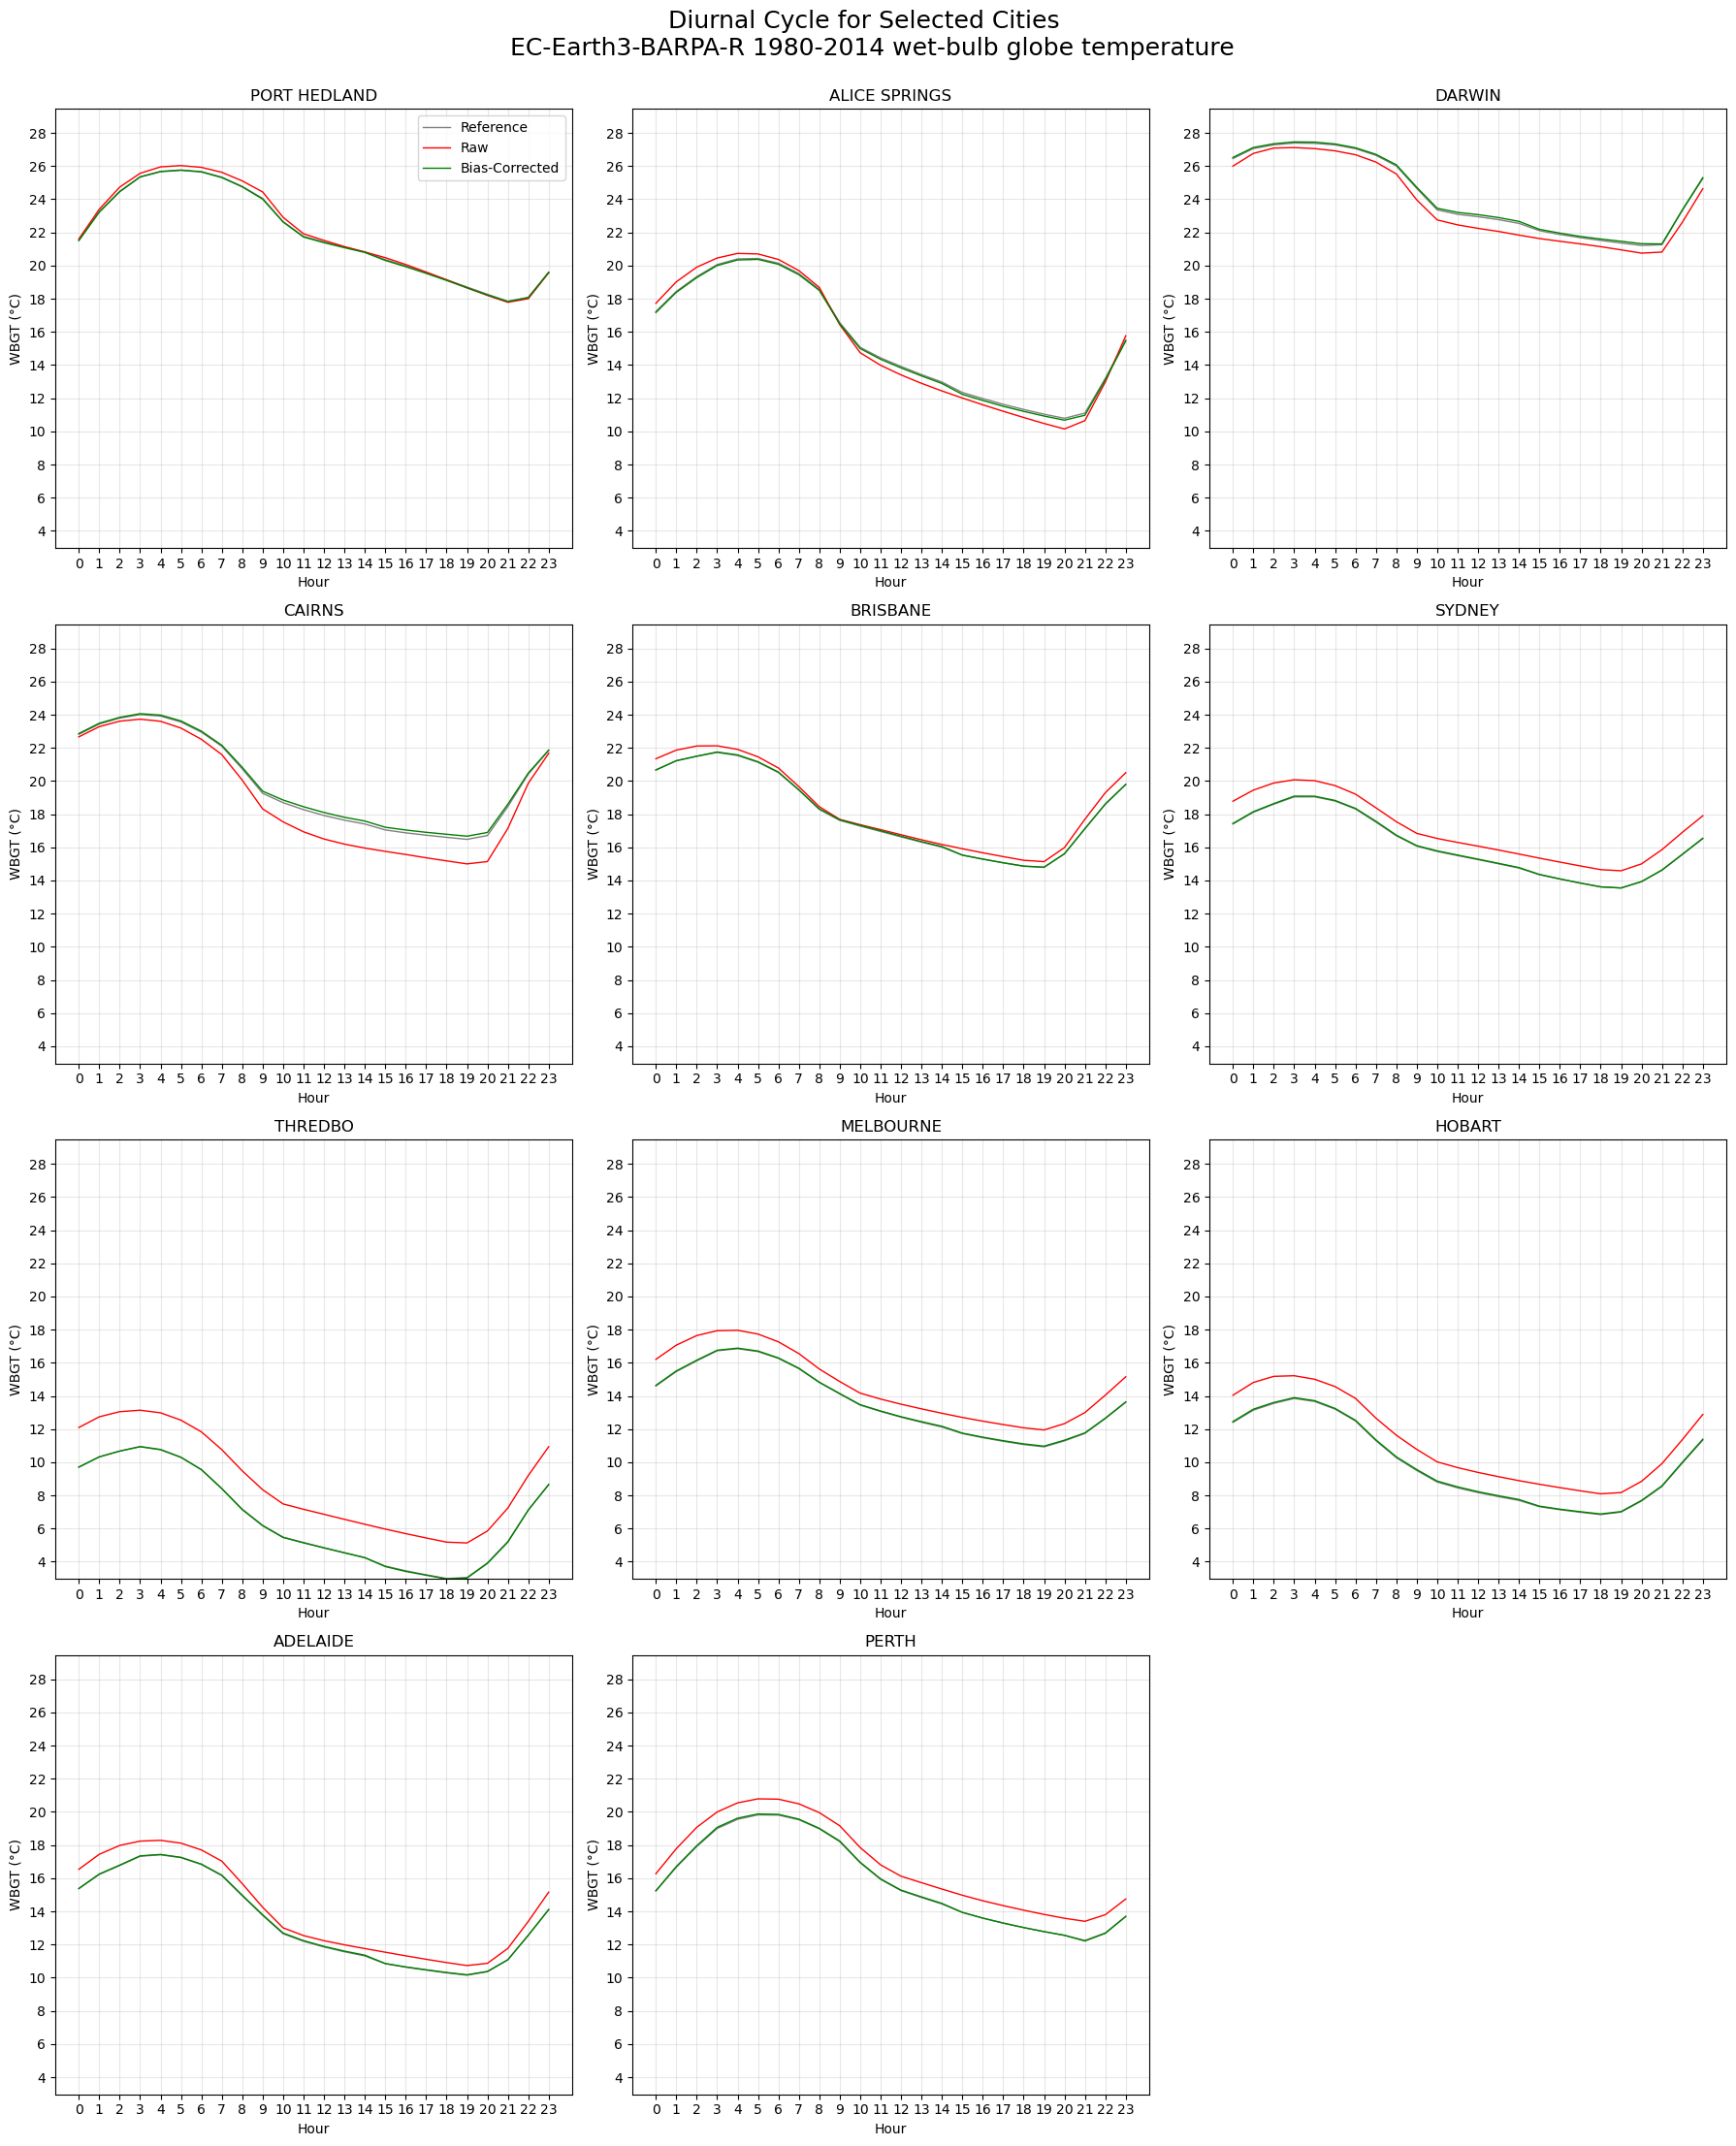

In [26]:
# Diurnal cycle for raw, corrected and reference for specific regions/location
task="diurnal-cycle-cities"
calc= "diurnal cycle cities"
# Get list of cities
cities_list = diurnal_df['City'].unique()
n_cities = len(cities_list)

# Plot
cols = 3
rows = (n_cities + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

# global y-axis limits for consistency
y_min = diurnal_df[['Hourly_Ref', 'Hourly_Raw', 'Hourly_BC']].min().min()
y_max = diurnal_df[['Hourly_Ref', 'Hourly_Raw', 'Hourly_BC']].max().max()

for i, city in enumerate(cities_list):
    ax = axes[i]
    diurnal_city = diurnal_df[diurnal_df['City'] == city]

    # Plot 
    ax.plot(diurnal_city['Hour'], diurnal_city['Hourly_Ref'], label='Reference', color='grey', linewidth=1)
    ax.plot(diurnal_city['Hour'], diurnal_city['Hourly_Raw'], label='Raw', color='red', linewidth=1)
    ax.plot(diurnal_city['Hour'], diurnal_city['Hourly_BC'], label='Bias-Corrected', color='green', linewidth=1)

    ax.set_title(city.upper())
    ax.set_xlabel('Hour')
    ax.set_ylabel('WBGT (°C)')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(24))
    ax.set_yticks([round(x, 1) for x in range(int(y_min), int(y_max) + 4, 2)])
    ax.set_ylim(y_min, y_max + 2)

    if i == 0:
        ax.legend()

plt.suptitle(f"Diurnal Cycle for Selected Cities \n {gcm}-{rcm} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {name}" , fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# # Compute bias
bias_raw = raw - ref
bias_corrected = corrected - ref

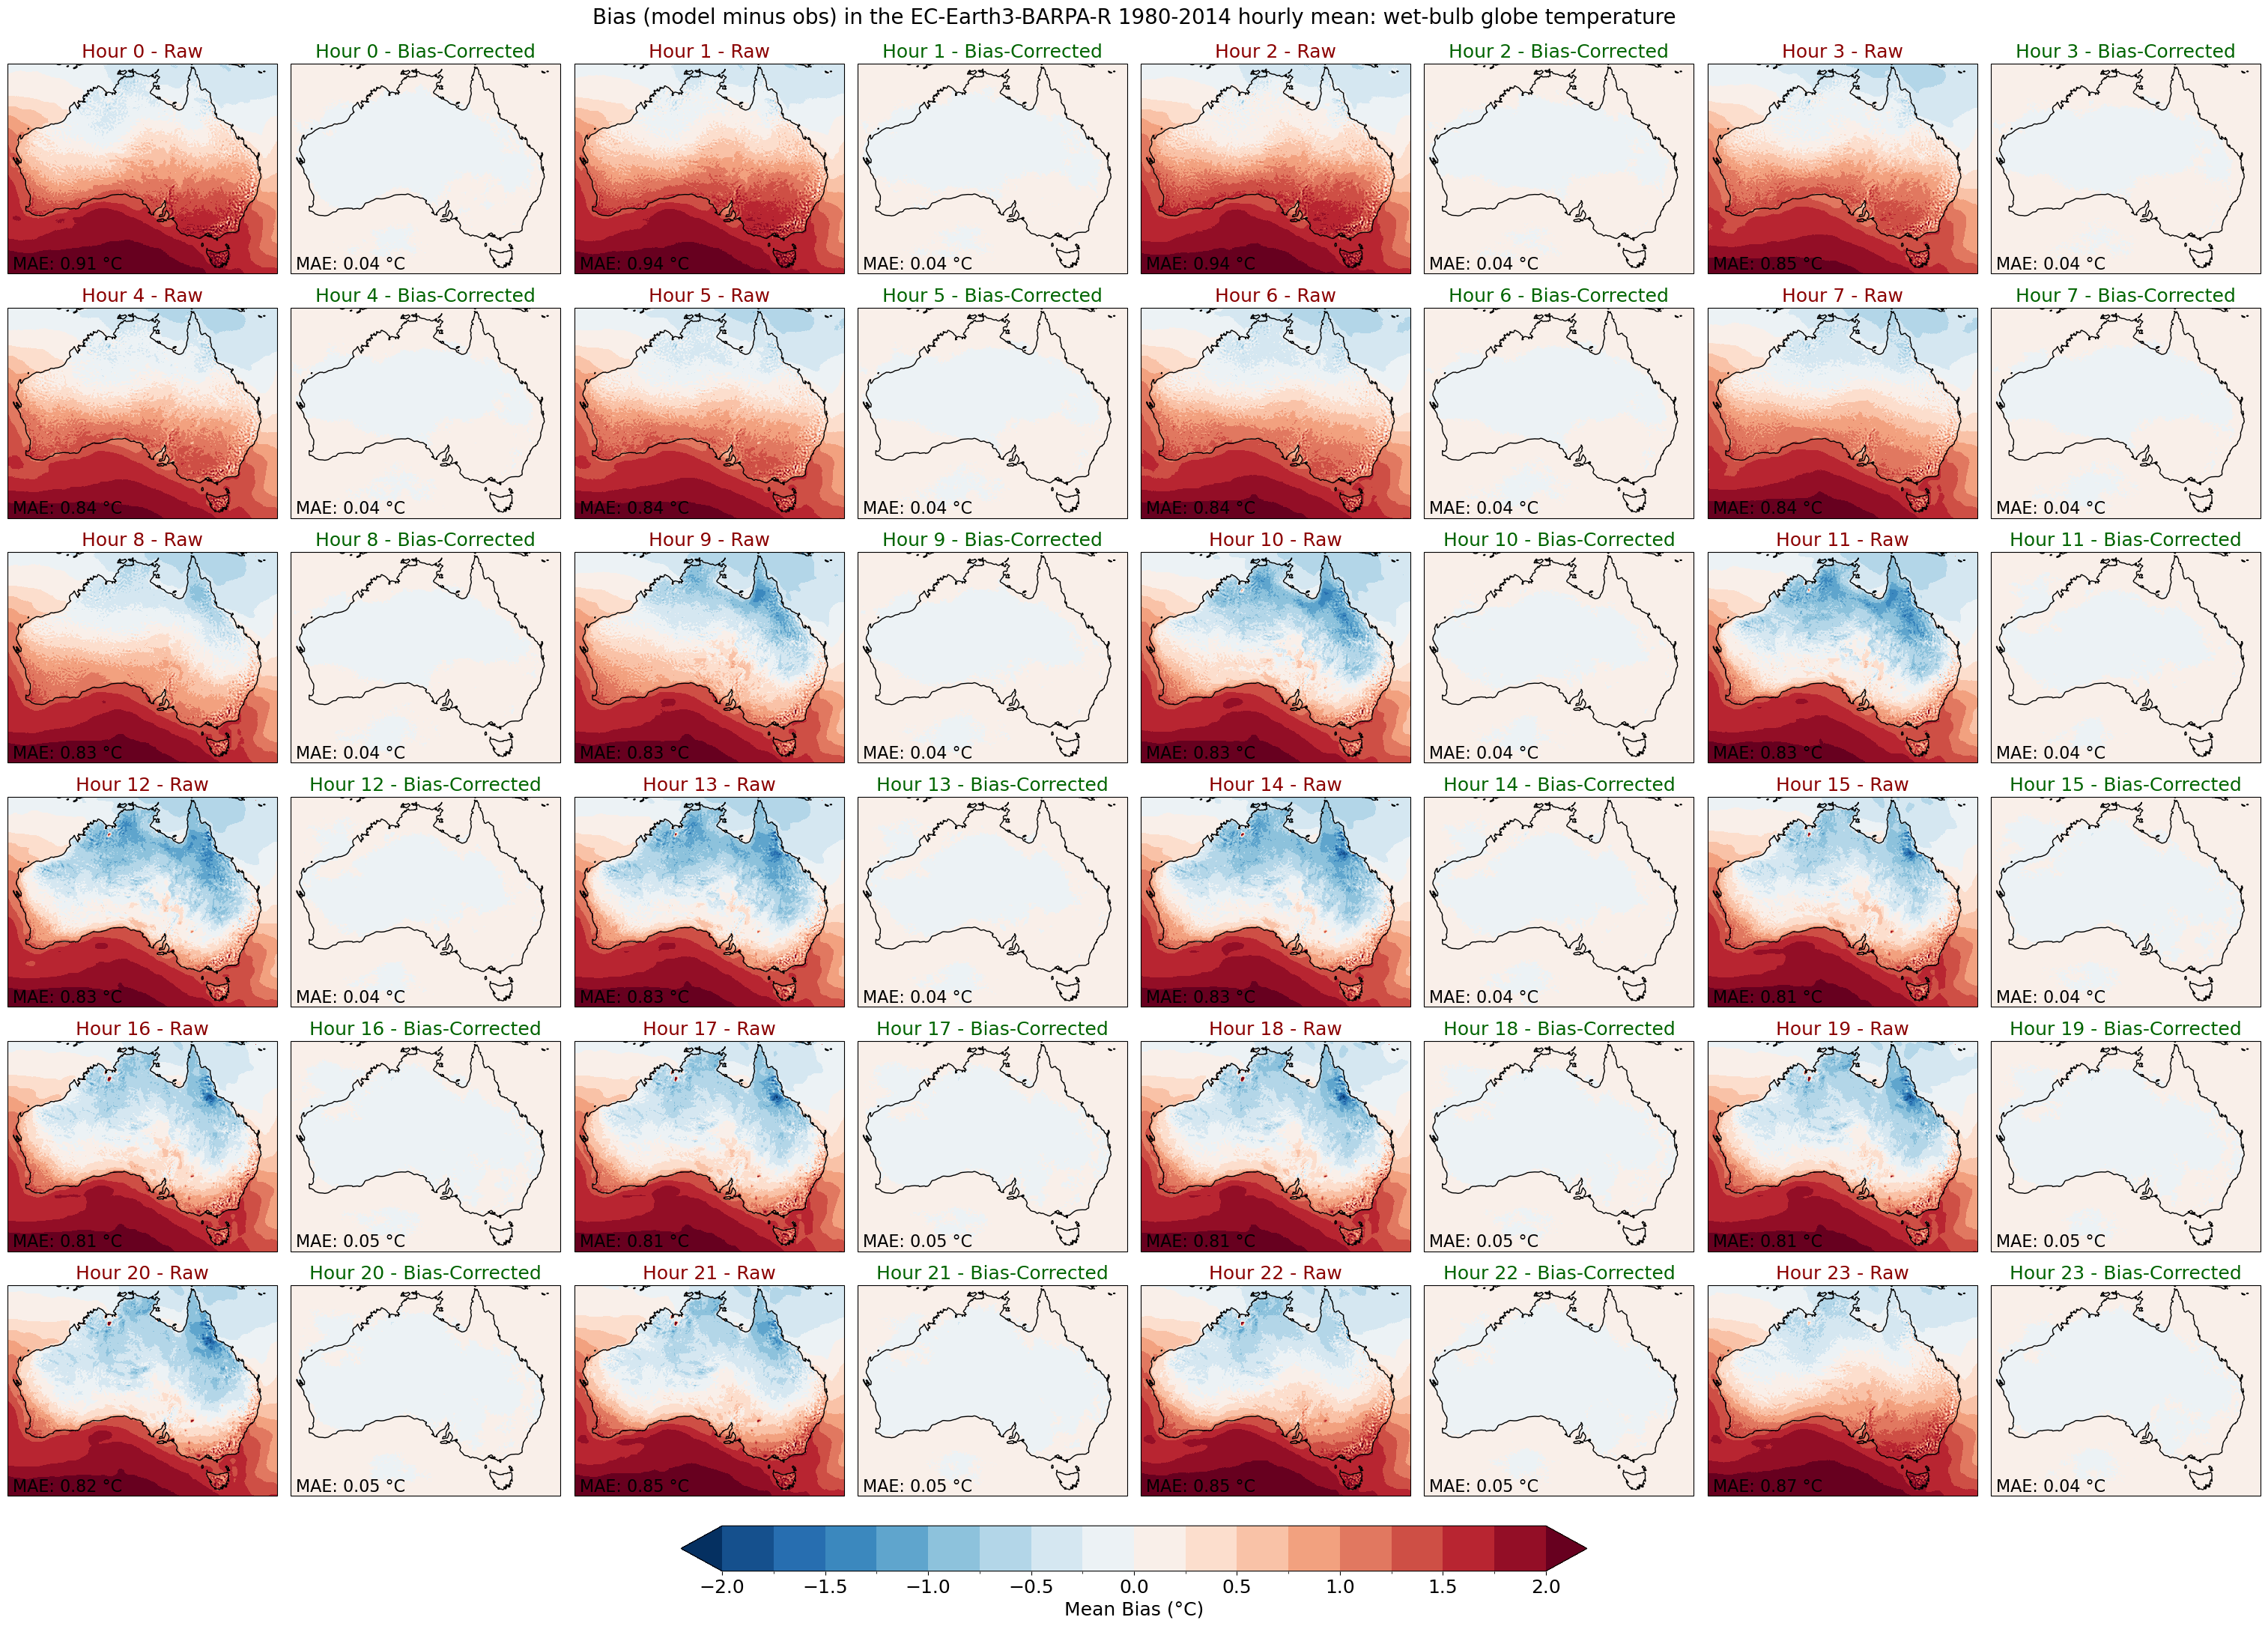

In [29]:
task="hourly_mean_bias"
calc= "hourly mean bias"

levels_bias = np.arange(-2, 2.25, 0.25)
cmap = 'RdBu_r'
units = '°C'

bias_stats = []

# Plot
nrows, ncols = 6, 8
fig, axes = plt.subplots(nrows, ncols, figsize=(32, 24),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# spacing between rows, columns, and title
fig.subplots_adjust(top=0.90, bottom=0.06, left=0.03, right=0.97, hspace=0.15, wspace=0.05)

# Plot each hour
for hour in range(24):
    bias_raw_hour = bias_raw.sel(time=bias_raw['time'].dt.hour == hour).mean(dim='time')
    bias_corrected_hour = bias_corrected.sel(time=bias_corrected['time'].dt.hour == hour).mean(dim='time')

    mae_raw = float(abs(bias_raw_hour).mean())
    mae_corrected = float(abs(bias_corrected_hour).mean())
 

    # Raw bias subplot
    ax_raw = axes[hour * 2]
    bias_raw_hour.plot(ax=ax_raw, transform=ccrs.PlateCarree(),
                       cmap=cmap, levels=levels_bias, extend='both', add_colorbar=False)
    ax_raw.text(0.02, 0.02, f'MAE: {mae_raw:.2f} {units}', transform=ax_raw.transAxes, fontsize=16)
    ax_raw.set_title(f'Hour {hour} - Raw', fontsize=18, color='darkred')
    ax_raw.coastlines()
    ax_raw.add_feature(cfeature.BORDERS, linewidth=0.5)
    

    # Corrected bias subplot
    ax_corrected = axes[hour * 2 + 1]
    bias_corrected_hour.plot(ax=ax_corrected, transform=ccrs.PlateCarree(),
                             cmap=cmap, levels=levels_bias, extend='both', add_colorbar=False)
    ax_corrected.text(0.02, 0.02, f'MAE: {mae_corrected:.2f} {units}', transform=ax_corrected.transAxes, fontsize=16)
    ax_corrected.set_title(f'Hour {hour} - Bias-Corrected', fontsize=18, color='darkgreen')
    ax_corrected.coastlines()
    ax_corrected.add_feature(cfeature.BORDERS, linewidth=0.5)

# Shared colorbar 
norm = mpl.colors.BoundaryNorm(boundaries=levels_bias, ncolors=plt.get_cmap(cmap).N, extend='both')
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', location='bottom', pad=0.02, fraction=0.03, extend='both')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(f'Mean Bias ({units})', fontsize=18)


fig.suptitle(f"Bias (model minus obs) in the {gcm}-{rcm} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} hourly mean: {name}",
             fontsize=20, y=0.93)
outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()

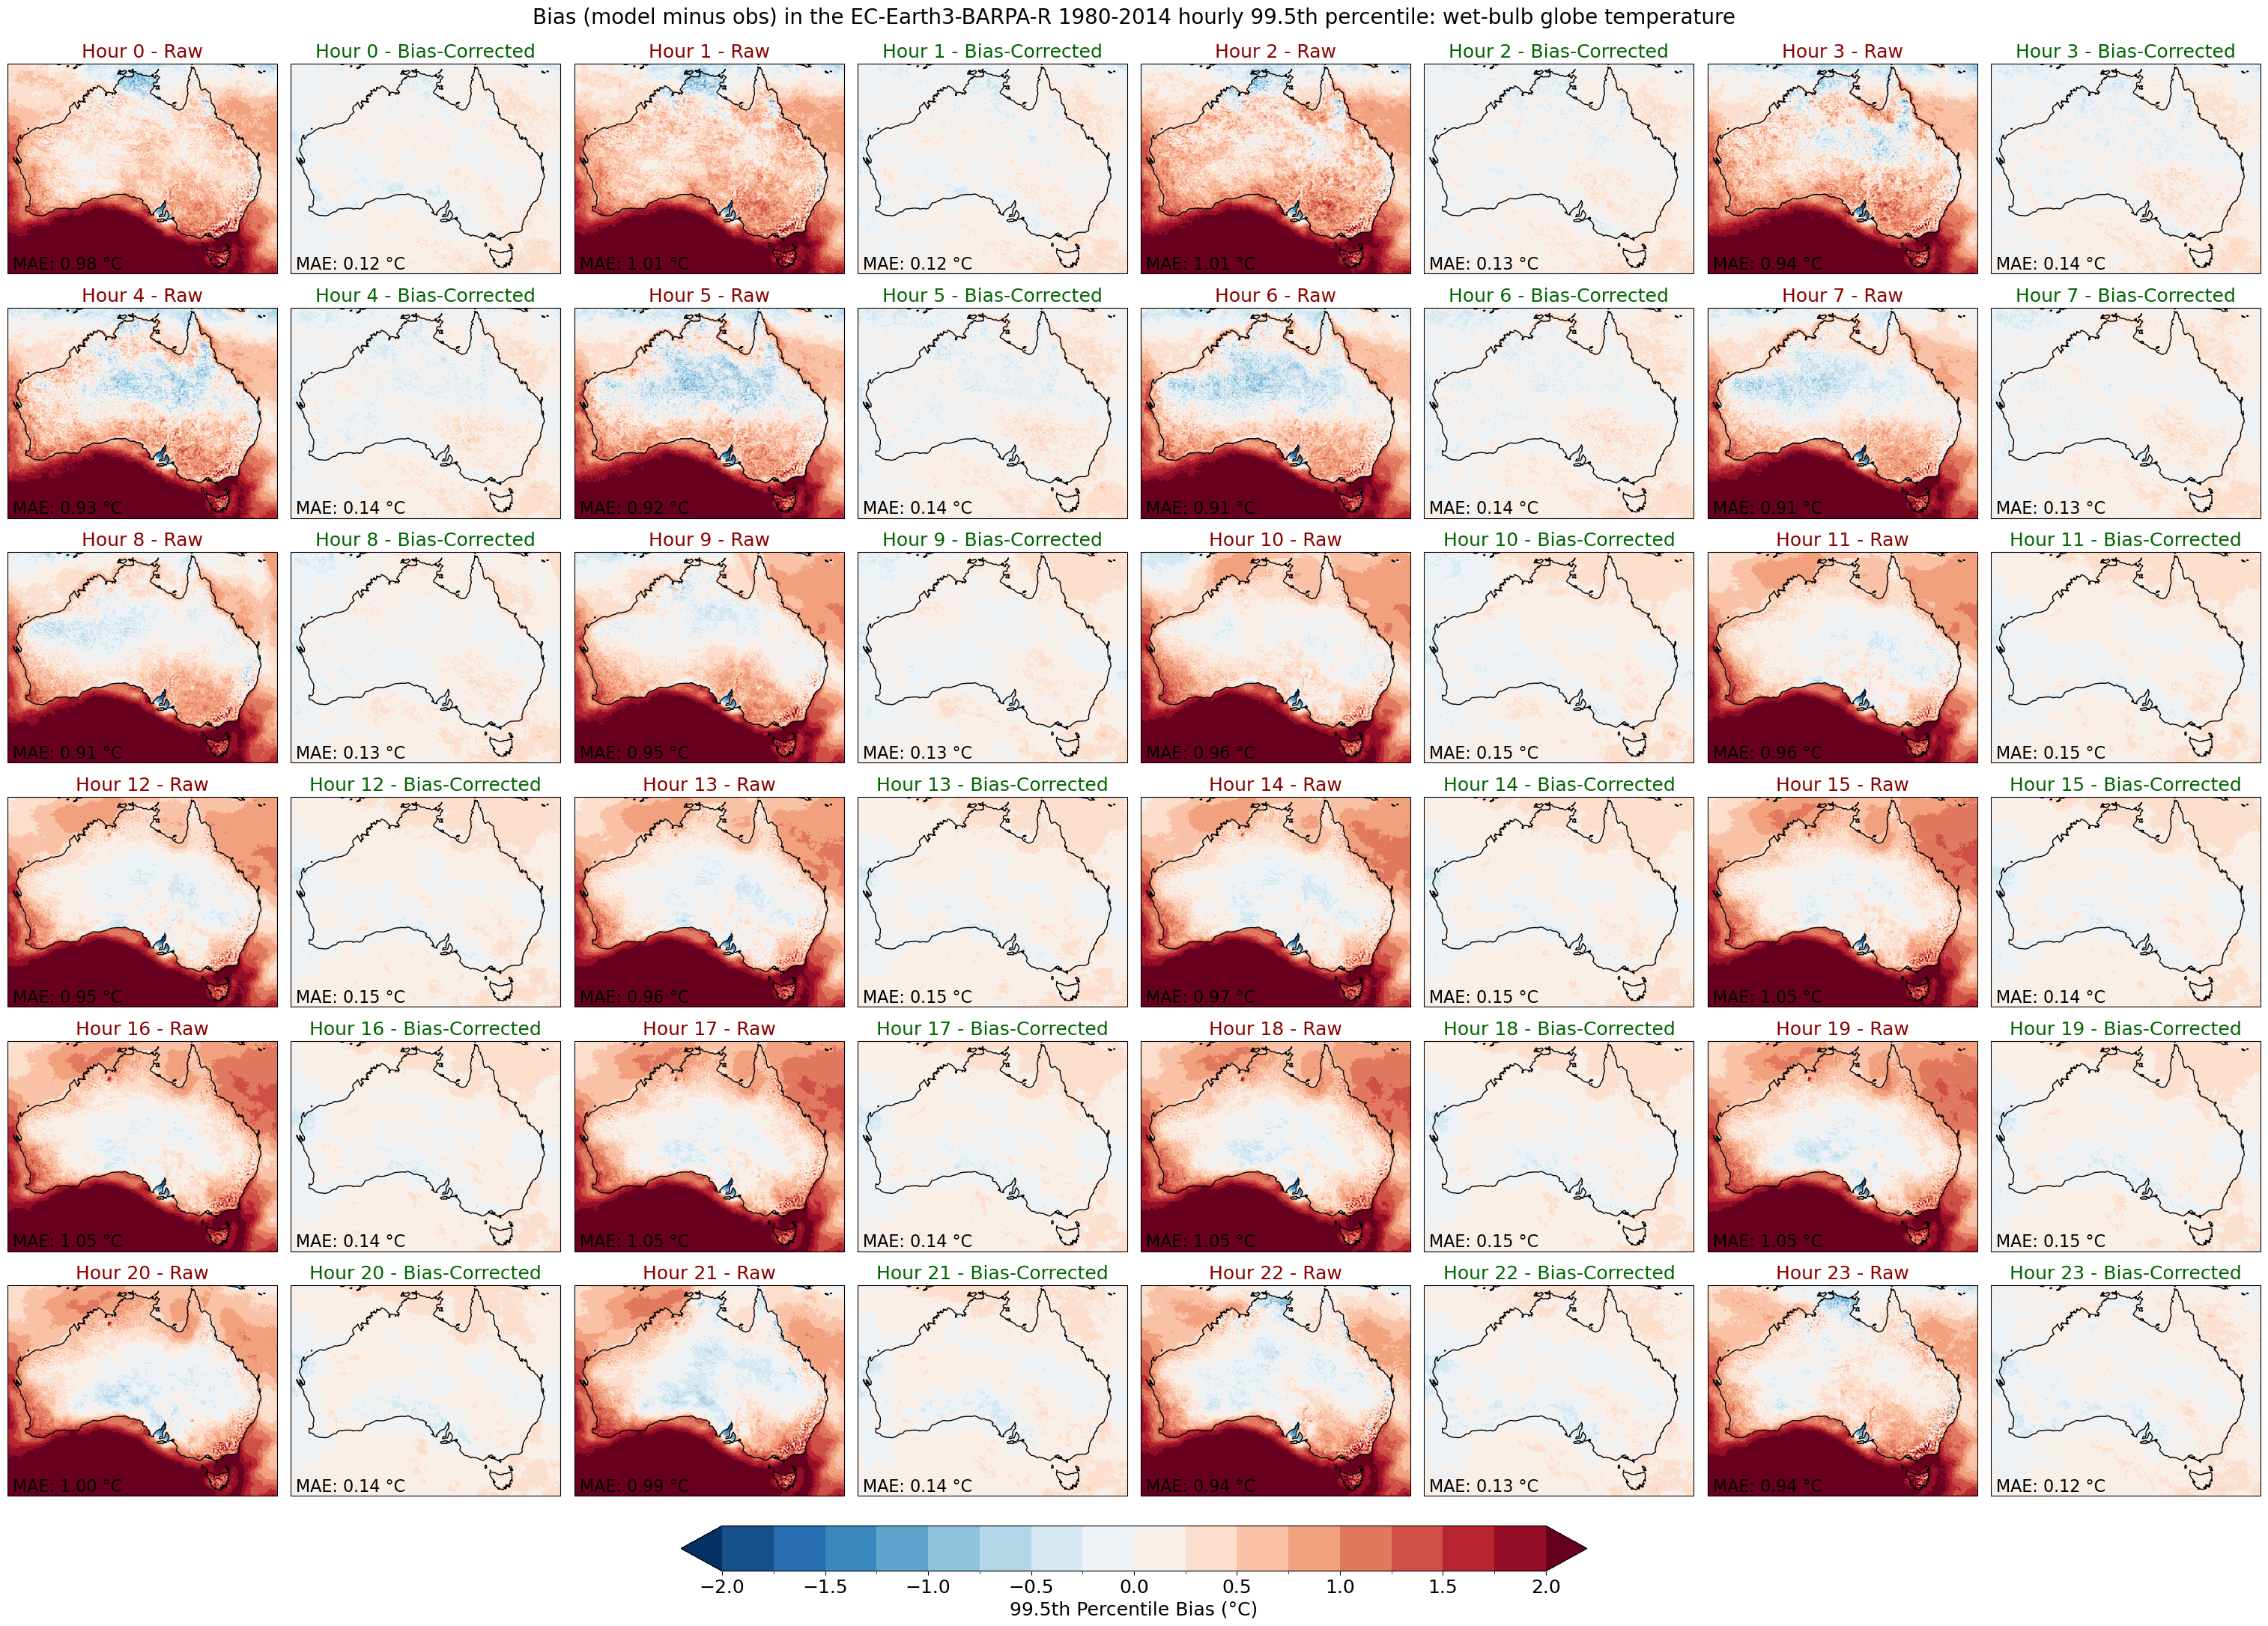

In [30]:
task="hourly_percentile_bias"
calc= "hourly percentile bias"

levels_bias = np.arange(-2, 2.25, 0.25)
cmap = 'RdBu_r'
units = '°C'

nrows, ncols = 6, 8
fig, axes = plt.subplots(nrows, ncols, figsize=(32, 24),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# spacing between rows, columns, and title
fig.subplots_adjust(top=0.90, bottom=0.06, left=0.03, right=0.97,
                    hspace=0.15, wspace=0.05)

# Plot each hour
for hour in range(24):
    ref_perc = ref.sel(time=ref['time'].dt.hour == hour).quantile(0.995, dim='time')
    raw_perc = raw.sel(time=raw['time'].dt.hour == hour).quantile(0.995, dim='time')
    corrected_perc = corrected.sel(time=corrected['time'].dt.hour == hour).quantile(0.995, dim='time')

    bias_raw_hour = raw_perc - ref_perc
    bias_corrected_hour = corrected_perc - ref_perc
    mae_raw = float(abs(bias_raw_hour).mean())
    mae_corrected = float(abs(bias_corrected_hour).mean())

    
    # Raw bias subplot
    ax_raw = axes[hour * 2]
    bias_raw_hour.plot(ax=ax_raw, transform=ccrs.PlateCarree(),
                       cmap=cmap, levels=levels_bias, extend='both', add_colorbar=False)
    ax_raw.text(0.02, 0.02, f'MAE: {mae_raw:.2f} {units}', transform=ax_raw.transAxes, fontsize=16)
    ax_raw.set_title(f'Hour {hour} - Raw', fontsize=18, color='darkred')
    ax_raw.coastlines()
    ax_raw.add_feature(cfeature.BORDERS, linewidth=0.5)

    # Corrected bias subplot
    ax_corrected = axes[hour * 2 + 1]
    bias_corrected_hour.plot(ax=ax_corrected, transform=ccrs.PlateCarree(),
                             cmap=cmap, levels=levels_bias, extend='both', add_colorbar=False)
    ax_corrected.text(0.02, 0.02, f'MAE: {mae_corrected:.2f} {units}', transform=ax_corrected.transAxes, fontsize=16)
    ax_corrected.set_title(f'Hour {hour} - Bias-Corrected', fontsize=18, color='darkgreen')
    ax_corrected.coastlines()
    ax_corrected.add_feature(cfeature.BORDERS, linewidth=0.5)

# Shared colorbar 
norm = mpl.colors.BoundaryNorm(boundaries=levels_bias, ncolors=plt.get_cmap(cmap).N, extend='both')
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', location='bottom', pad=0.02, fraction=0.03, extend='both')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(f'99.5th Percentile Bias ({units})', fontsize=18)

fig.suptitle(f"Bias (model minus obs) in the {gcm}-{rcm} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} hourly 99.5th percentile: {name}", fontsize=20, y=0.93)
outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()